In [1]:
import utils
from utils import *
import importlib
import numpy as np
import pandas as pd
import pprint
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import math, time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
import tensorflow
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Conv2D, Reshape, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization, ZeroPadding2D




<module 'utils' from 'D:\\gatech\\ML\\unsupervised_learning\\utils.py'>

In [33]:
def load_data(clean=False):
    print("loading data...")
    df_train = pd.read_csv("data/mnist/csv_format/train.csv")
    df_test = pd.read_csv("data/mnist/csv_format/test.csv")
    X = []
    y = []
    for row in df_train.iterrows() :
        label = row[1][0] # label (the number visible in the image)
        image = list(row[1][1:]) # image information as list, without label
        image = np.array(image)
        X.append(image)
        y.append(label)

    X = np.array(X)
    y = np.array(y)
    if clean:
        X = StandardScaler().fit_transform(X)
    return(X, y)

def split_data(X, y, data_size=1.0, train_size=0.8, strat=False):
    if strat:
        sss = StratifiedShuffleSplit(n_splits=1, random_state=0, train_size=train_size, test_size=train_size/4)
        for train_index, test_index in sss.split(X, y):
            print("hm")
            X_train = X[train_index]
            X_test = X[test_index]
            y_train, y_test = y[train_index], y[test_index]
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size=train_size/4)
    return(X_train, y_train, X_test, y_test)

def k_means_elbow_viz(X, k_range=(2, 15)):
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=k_range)
    visualizer.fit(X)
    visualizer.show()

def k_means_silhouette(X, range_n_clusters =[2, 3, 4, 5, 6, 7, 8, 9, 10]):


    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

    plt.show()


def GMM_elbow(X, y, range_n_clusters=[1, 2, 3, 4, 5, 6]):
    aics = []
    bics = []
    scores = []
    for i in range_n_clusters:
        gmm = GMM(random_state=13, n_components=i)
        gmm.fit(X)
        aics.append(gmm.aic(X))
        bics.append(gmm.bic(X))
        scores.append(gmm.score(X, y))
    plt.plot(range_n_clusters, aics, label="AIC")
    plt.plot(range_n_clusters, bics, label="BIC")
    plt.xlabel ("n clusters")
    plt.ylabel ("AIC/BIC")
    plt.legend()
    plt.title ("AIC/BIC elbow method per n_clusters")
    plt.show()



def build_pc_col_names(num):
    col_vals = []
    for i in range(1, num+1):
        col_vals.append(i)
    return col_vals

def compare_comp_vals_PCA(X, y, vals_range=[1, 2, 3, 4, 5, 6, 7]):
    result_dfs = []
    n_comp_vals = vals_range
    for comp_val in n_comp_vals:
        print("uh")
        pca = PCA(n_components=comp_val)
        col_vals = build_pc_col_names(comp_val)
        components = pca.fit_transform(X)

        pdf = pd.DataFrame(data = components
                     , columns = col_vals)
        pdy = pd.DataFrame(data=y, columns=["labels"])
        finalDf = pd.concat([pdf, pdy], axis = 1)
        result_dfs.append(finalDf)

        variance_ratio = pd.DataFrame({'var':pca.explained_variance_ratio_,
                     'PC':col_vals})
        sns.barplot(x='PC',y="var", data=variance_ratio, color="c");
        plt.show()
        plt.clf()
    return result_dfs

def pca_experiment(X, y, n_components, variance_thresh, visualize=True):
    pca = PCA(n_components=n_components)
    col_vals = build_pc_col_names(n_components)
    components = pca.fit_transform(X)
    print(X.shape)
    print(components.shape)

    pdf = pd.DataFrame(data = components
                 , columns = col_vals)
    pdy = pd.DataFrame(data=y, columns=["labels"])
    finalDf = pd.concat([pdf, pdy], axis = 1)
    variance_ratio = pd.DataFrame({'var':pca.explained_variance_ratio_,
                 'PC':col_vals})
    if visualize:
        sns.barplot(x='PC',y="var", data=variance_ratio, color="c");
        plt.show()
        plt.clf()
    cumsum = 0
    last_col_to_keep = 0
    for i in range(n_components):
        print(variance_ratio['var'][i])
        if cumsum < variance_thresh:
            print("yes")
            cumsum += variance_ratio['var'][i]
            last_col_to_keep = i
    print(components.shape)
    components_to_keep = components[:, :last_col_to_keep]
    print(components_to_keep.shape)
    return(components_to_keep)

def analyze_ICA(X, n_components, visualize=True):
    rec_err = []
    avg_kurts = []
    best_kurt = -9999
    best_n_comp_val = 0
    maxComponents = 8
    minComponents = 1
    comp_range = range(1, n_components, 100)
    for i in comp_range:
        print(i)
        ica = FastICA(n_components=i)
        ica.fit(X)
        rec_err.append(reconstructionError(ica,X))
        kurt = np.average(kurtosis(ica.components_))
        avg_kurts.append(kurt)
        if kurt > best_kurt:
            best_kurt = kurt
            best_n_comp_val = i
    if visualize:
        plt.figure(figsize=(6, 4))
        plt.plot(comp_range,
                 avg_kurts,
                 'bo',
                 comp_range,avg_kurts,'k')
        plt.xlabel('Number of Components')
        plt.ylabel('Average Kurtosis')
        plt.title('ICA - Kurtosis by Number of Components')
        plt.tight_layout()
        plt.show()


        plt.figure(figsize=(6, 4))
        plt.plot(comp_range,
                 rec_err,
                 'bo',
                 comp_range,
                 rec_err,
                 'k')
        plt.xlabel('Number of Components')
        plt.ylabel('Reconstruction Error')
        plt.title('ICA - Error by Number of Components')
        plt.tight_layout()
        plt.show()
    return best_n_comp_val, best_kurt
  

def ica_experiment(X, y, n_comps, visualize=True):
    columns_na = []
    for i in range(1, n_comps + 1):
        columns_na.append("ic " + str(i))
    transformer = FastICA(n_components=n_comps, random_state=0)
    X_transformed = transformer.fit_transform(X)
    X_transformed.shape
    pdf = pd.DataFrame(data = X_transformed, columns = columns_na)
    pdy = pd.DataFrame(data=y, columns=['labels'])
    icaDf = pd.concat([pdf, pdy], axis = 1)
    if visualize:
        fig = plt.figure(figsize = (8,8))
        ax = fig.add_subplot(1,1,1)
        ax.set_xlabel('ic 1', fontsize = 15)
        ax.set_ylabel('ic 2', fontsize = 15)
        ax.set_title('ICA', fontsize = 20)
        targets = [0, 1]
        colors = ['r', 'g']
        for target, color in zip(targets,colors):
            points_in_label = icaDf['labels'] == target
            ax.scatter(icaDf.loc[points_in_label, 'ic 1']
                       , icaDf.loc[points_in_label, 'ic 2']
                       , c = color
                       , s = 50)
        ax.legend(targets)
        ax.grid()

        fig = plt.figure(figsize = (8,8))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_xlabel('ic 1', fontsize = 15)
        ax.set_ylabel('ic 2', fontsize = 15)
        ax.set_zlabel('ic 3', fontsize = 15)
        ax.set_title('ICA', fontsize = 20)
        targets = [0, 1]
        colors = ['g', 'r']
        for target, color in zip(targets,colors):
            points_in_label = icaDf['labels'] == target
            ax.scatter(icaDf.loc[points_in_label, 'ic 1']
                       , icaDf.loc[points_in_label, 'ic 2']
                       , icaDf.loc[points_in_label, 'ic 3']
                       , c = color
                       , s = 50)
        ax.legend(targets)
        #ax.set_ylim(-1, 1)
        ax.grid()

    return icaDf

def run_PCA(X,y,title):

    pca = PCA(random_state=5).fit(X) #for all components
    cum_var = np.cumsum(pca.explained_variance_ratio_)

    fig, ax1 = plt.subplots()
    ax1.plot(list(range(len(pca.explained_variance_ratio_))), cum_var, 'b-')
    ax1.set_xlabel('Principal Components')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax1.set_ylabel('Cumulative Explained Variance Ratio', color='b')
    ax1.tick_params('y', colors='b')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(list(range(len(pca.singular_values_))), pca.singular_values_, 'm-')
    ax2.set_ylabel('Eigenvalues', color='m')
    ax2.tick_params('y', colors='m')
    plt.grid(False)

    plt.title("PCA Explained Variance and Eigenvalues: "+ title)
    fig.tight_layout()
    plt.show()

def run_ICA(X,y,title): #when kurtosis high, components less gaussian, more independent

    dims = list(np.arange(2,(X.shape[1]-1),3))
    #dims = list(np.arange(2,80,3))
    dims.append(X.shape[1])
    ica = FastICA(random_state=5)
    kurt = []

    for dim in dims:
        print(dim)
        ica.set_params(n_components=dim)
        tmp = ica.fit_transform(X)
        tmp = pd.DataFrame(tmp)
        tmp = tmp.kurt(axis=0)
        kurt.append(tmp.abs().mean())

    plt.figure()
    plt.title("ICA Kurtosis: "+ title)
    plt.xlabel("Independent Components")
    plt.ylabel("Avg Kurtosis Across IC")
    plt.plot(dims, kurt, 'b-')
    plt.grid(False)
    plt.show()

def run_SparseRandomProjection(X,title):

    dims = list(np.arange(2,(X.shape[1]-1),100))
    print(dims)
    dims.append(X.shape[1])
    tmp = defaultdict(dict)
    for i,dim in product(range(5),dims):
        print(i)
        rp = SparseRandomProjection(random_state=i, n_components=dim)
        tmp[dim][i] = pairwiseDistCorr(rp.fit_transform(X), X)
    tmp = pd.DataFrame(tmp).T
    mean_recon = tmp.mean(axis=1).tolist()
    std_recon = tmp.std(axis=1).tolist()


    fig, ax1 = plt.subplots()
    ax1.plot(dims,mean_recon, 'b-')
    ax1.set_xlabel('Random Components')
    ax1.set_ylabel('Mean Reconstruction Correlation', color='b')
    ax1.tick_params('y', colors='b')
    plt.grid(False)

    ax2 = ax1.twinx()
    ax2.plot(dims,std_recon, 'm-')
    ax2.set_ylabel('STD Reconstruction Correlation', color='m')
    ax2.tick_params('y', colors='m')
    plt.grid(False)

    plt.title("Random Components for 5 Restarts: "+ title)
    fig.tight_layout()
    plt.show()

def RP_experiment(X, n_comps, visualize=True):
    rp = SparseRandomProjection(n_components=n_comps)
    X_new = rp.fit_transform(X)
    return(X_new)

def RFC_experiment(X, y, threshold=0.8, visualize=True):
    print(X)
    X_copy = X.copy()
    rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
    rnd_clf.fit(X, y)
    print(rnd_clf.feature_importances_)
    #zipped = zip(df.columns[:-1], rnd_clf.feature_importances_)
    #for name, importance in zipped:
    #    print(name, "=", importance)
    #zipped = list(zip(df.columns[:-1], rnd_clf.feature_importances_))
    #print(zipped)
    #res = sorted(zipped, key = lambda x: x[1], reverse=True)
    #print(res)

    #indices = np.argsort(rnd_clf.feature_importances_)
    #print(indices)

    #cumsum = 0
    #useful_cols = []
    #useful_indices = []
    #i = 0
    #while cumsum < threshold:
    #    cumsum += res[i][1]
    #    useful_cols.append(res[i][0])
    #    i+=1

    #for column, idx in zip(df.columns[:-1], x_indices):
    #    if column in useful_cols:
    #        useful_indices.append(idx)
    #print("hm ",useful_indices)
    #print(X_copy.shape)
    #X_copy = X_copy[:, useful_indices]
    #print(X_copy.shape)
    if visualize:
        plt.title('Feature Importances')
        plt.barh(range(len(indices)), rnd_clf.feature_importances_[indices], color='b', align='center')
        plt.yticks(range(len(indices)), [df.columns[:-1][i] for i in indices])
        plt.xlabel('Relative Importance')
        plt.show()
    return(X_copy)



def pairwiseDistCorr(X1,X2):
    assert X1.shape[0] == X2.shape[0]

    d1 = pairwise_distances(X1)
    d2 = pairwise_distances(X2)
    return np.corrcoef(d1.ravel(),d2.ravel())[0,1]

def reconstructionError(projections,X):
    W = projections.components_
    if sps.issparse(W):
        W = W.todense()
    p = pinv(W)
    reconstructed = ((p@W)@(X.T)).T
    errors = np.square(X-reconstructed)
    return np.nanmean(errors)

In [4]:
X, y = load_data(clean=True)

loading data...


In [5]:
print(X.shape)
print(y.shape)

(42000, 784)
(42000,)


In [6]:
X_train, y_train, X_test, y_test =split_data(X, y, data_size=1.0, 
                                             train_size=0.08, strat=False)

In [7]:
print(X_train.shape)
print(y_train.shape)

(3360, 784)
(3360,)


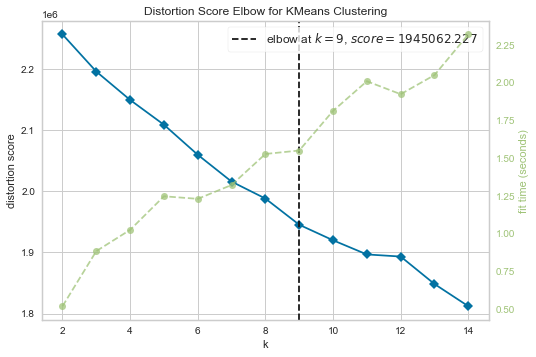

In [9]:
k_means_elbow_viz(X_train)

For n_clusters = 2 The average silhouette_score is : 0.11684843315881675
For n_clusters = 3 The average silhouette_score is : 0.052613413201368954
For n_clusters = 4 The average silhouette_score is : 0.040711148118257226
For n_clusters = 5 The average silhouette_score is : 0.03924464383095603
For n_clusters = 6 The average silhouette_score is : 0.0016733034741701336
For n_clusters = 7 The average silhouette_score is : 0.00042946183330964645
For n_clusters = 8 The average silhouette_score is : 0.00010739428147110747
For n_clusters = 9 The average silhouette_score is : -0.002240316856132047
For n_clusters = 10 The average silhouette_score is : -0.0012529385860172671


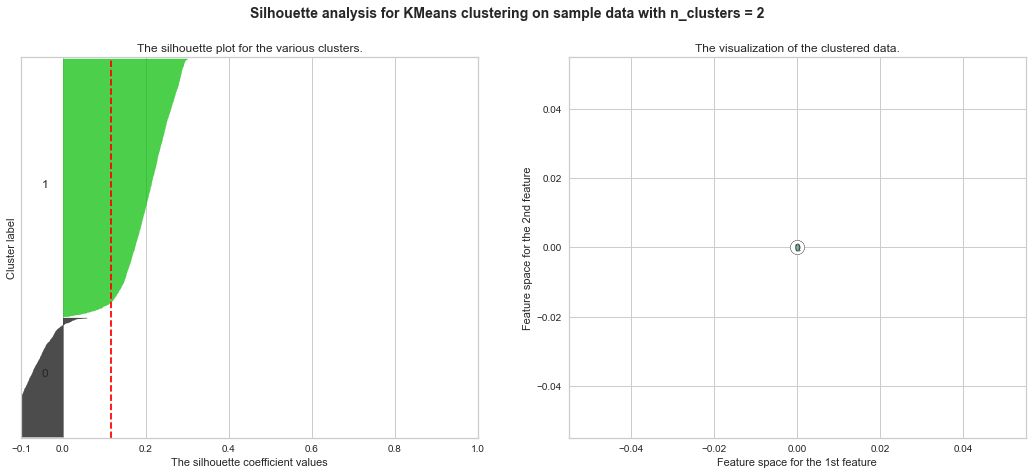

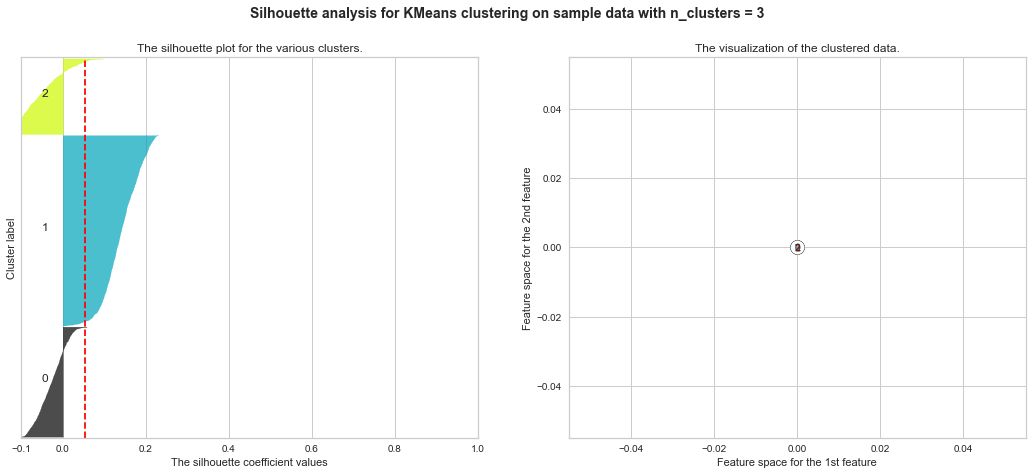

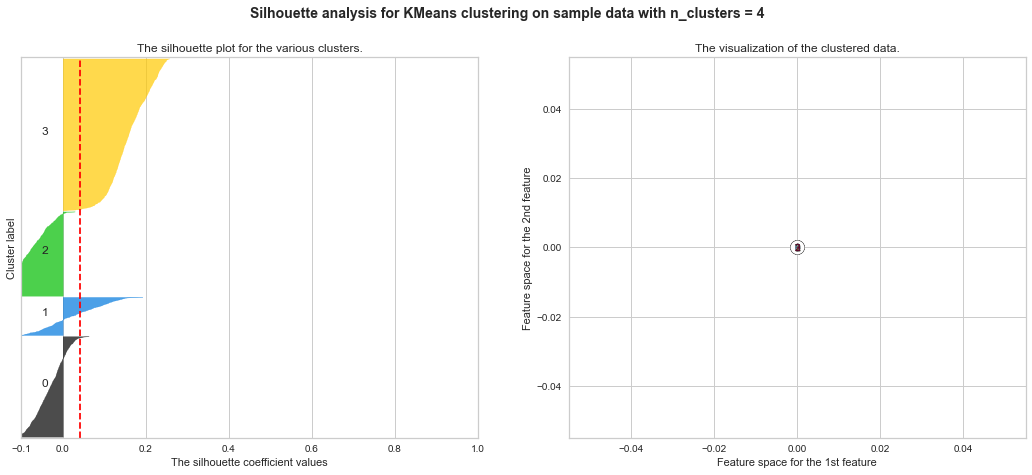

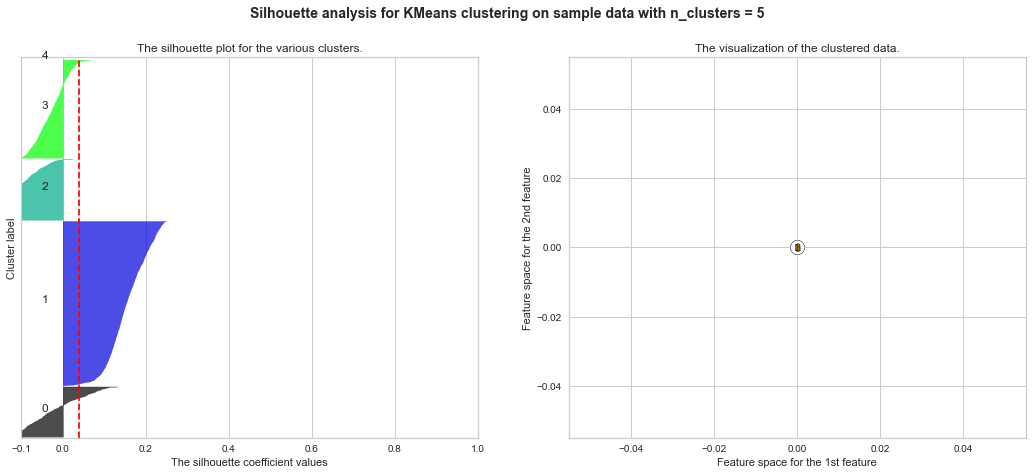

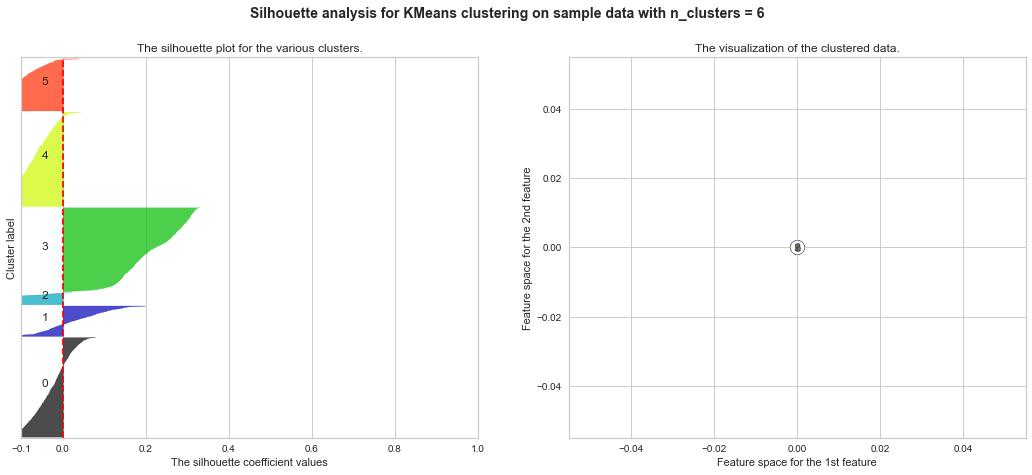

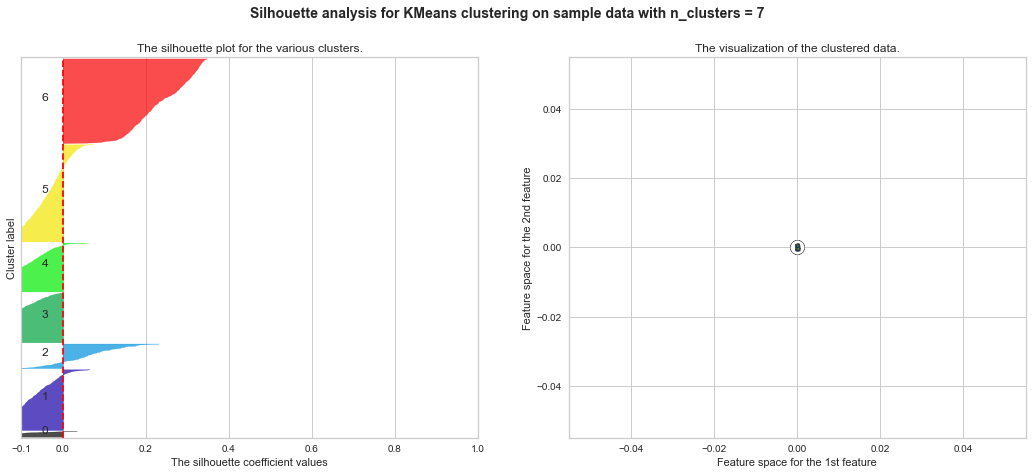

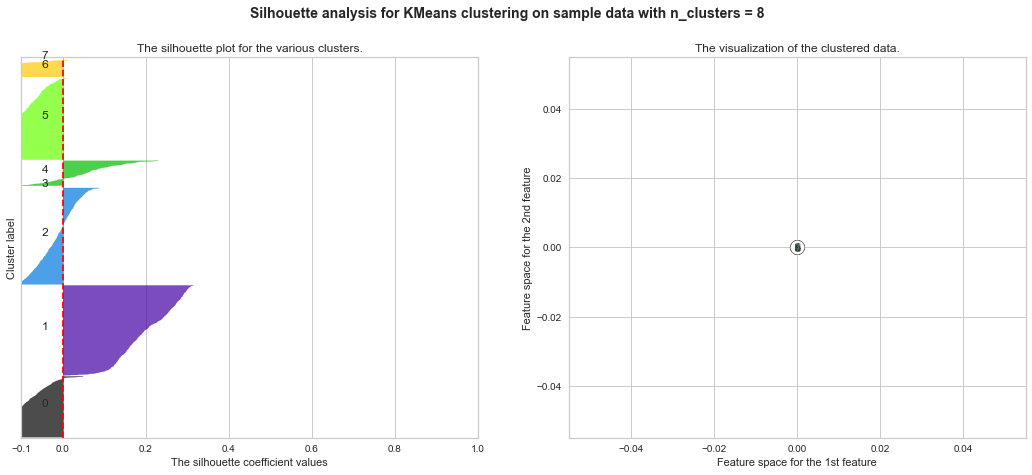

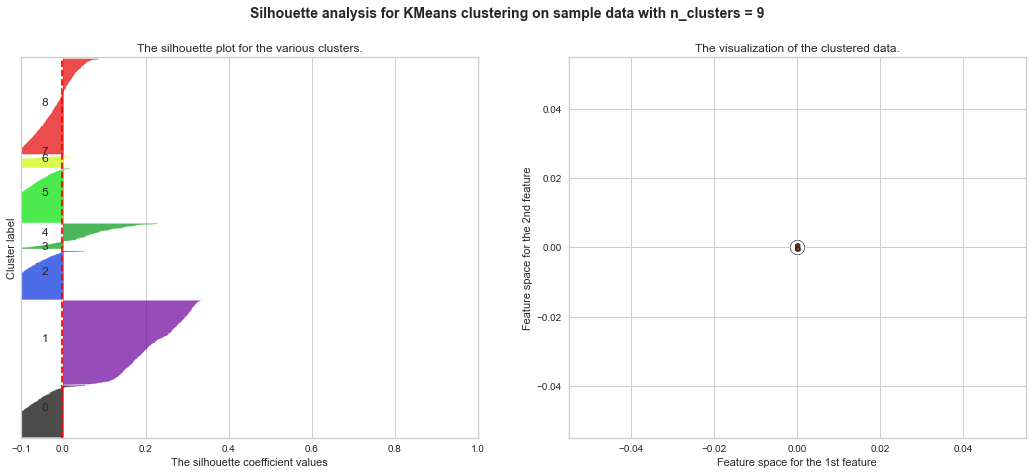

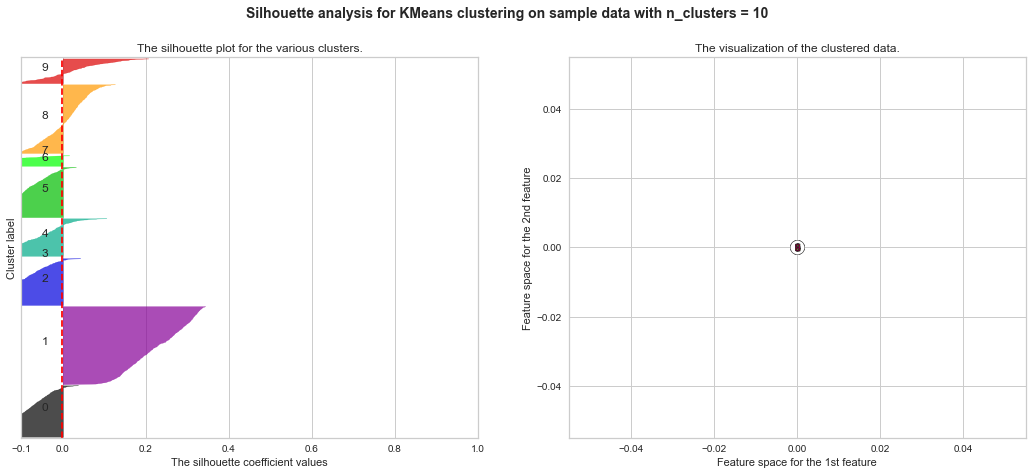

In [10]:
k_means_silhouette(X_train)

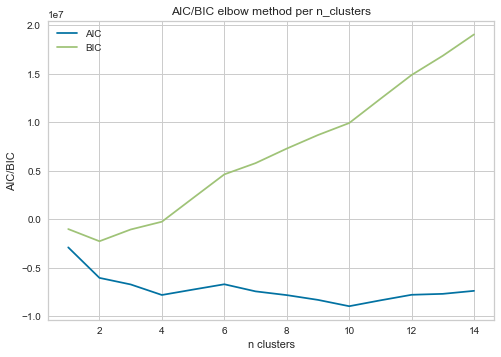

In [12]:
GMM_elbow(X_train, y_train, range_n_clusters=range(1, 15))

(3360, 784)
(3360, 784)


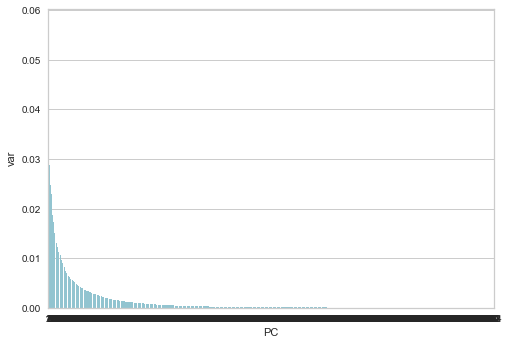

0.057410865006088406
yes
0.04417567120845604
yes
0.03814640756859697
yes
0.028861508064059894
yes
0.02582551764819872
yes
0.024725688617487217
yes
0.022881268243333582
yes
0.02168791859721595
yes
0.018777497674285215
yes
0.01749362325071292
yes
0.017209860334411804
yes
0.01642853860093009
yes
0.015080621510734412
yes
0.014690677898839506
yes
0.014286444178162258
yes
0.013072232313490998
yes
0.012296175407918667
yes
0.012203671566113109
yes
0.011813544780698593
yes
0.011210199342358075
yes
0.011019115484864792
yes
0.01062227025081198
yes
0.01054762051688749
yes
0.010027963018601715
yes
0.009623428570722504
yes
0.009301836457688593
yes
0.0091285062022432
yes
0.008727760997304514
yes
0.008362571636211619
yes
0.008244888138007628
yes
0.007748602647817926
yes
0.007458517981123343
yes
0.007285404842780666
yes
0.006930917585213104
yes
0.006844374431596129
yes
0.006739112415656226
yes
0.006462384402111464
yes
0.006316048703254976
yes
0.006134304238262047
yes
0.0059689042628472576
yes
0.0058340

<Figure size 576x396 with 0 Axes>

In [14]:
pca_X = pca_experiment(X_train, y_train, 784, 0.95)

In [15]:
print(pca_X.shape)

(3360, 230)


1
101
201
301
401
501


c:\users\fuers\anaconda3\envs\ml\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


601


c:\users\fuers\anaconda3\envs\ml\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


701


c:\users\fuers\anaconda3\envs\ml\lib\site-packages\sklearn\decomposition\_fastica.py:120: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


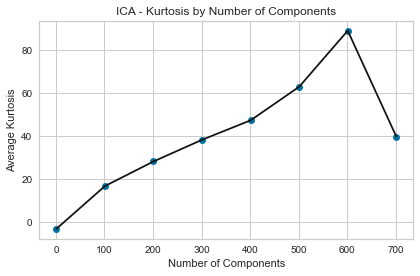

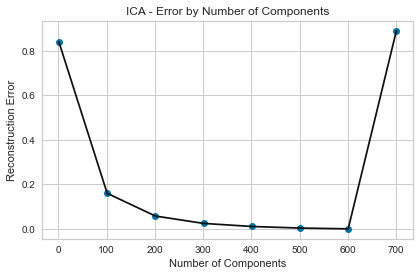

601


TypeError: only integer scalar arrays can be converted to a scalar index

In [38]:
best_n_comp_val, best_kurt = analyze_ICA(X_train, 784)
print(best_n_comp_val)
ica_X = ica_experiment(X_train, y_train, best_n_comp_val)

[2, 102, 202, 302, 402, 502, 602, 702]
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4


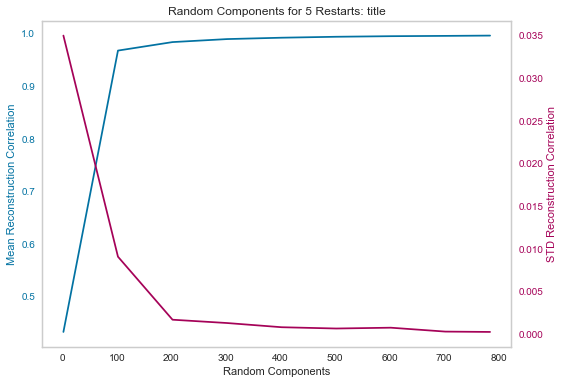

In [30]:
run_SparseRandomProjection(X_train,"title")
RP_X = RP_experiment(X_train, 5)

In [ ]:
data_directory = "data/"
filename = "diabetes.csv"
df = pd.read_csv(data_directory + filename)
indices = range(0,len(df.columns[:-1]))
RFC_X = RFC_experiment(X_train, y_train, df.columns[:-1], x_indices=indices)

In [ ]:
print(pca_X.shape)
print(ica_X.shape)
print(RP_X.shape)
print(RFC_X.shape)

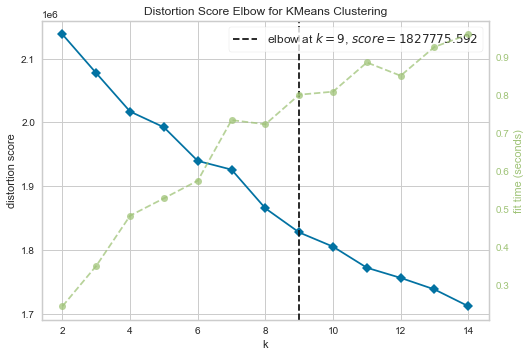

For n_clusters = 2 The average silhouette_score is : 0.12799663508914513
For n_clusters = 3 The average silhouette_score is : 0.054377259093594345
For n_clusters = 4 The average silhouette_score is : 0.04684514476740899
For n_clusters = 5 The average silhouette_score is : 0.04308744896884542
For n_clusters = 6 The average silhouette_score is : 0.043948177695280526
For n_clusters = 7 The average silhouette_score is : 0.029331200456613776
For n_clusters = 8 The average silhouette_score is : 0.018270172966856336
For n_clusters = 9 The average silhouette_score is : 0.010690118900086918
For n_clusters = 10 The average silhouette_score is : 0.003536138478849096


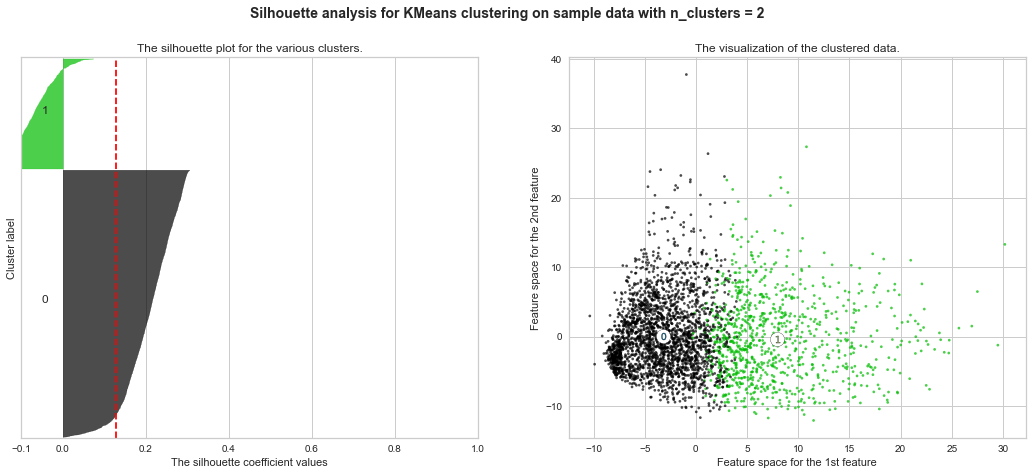

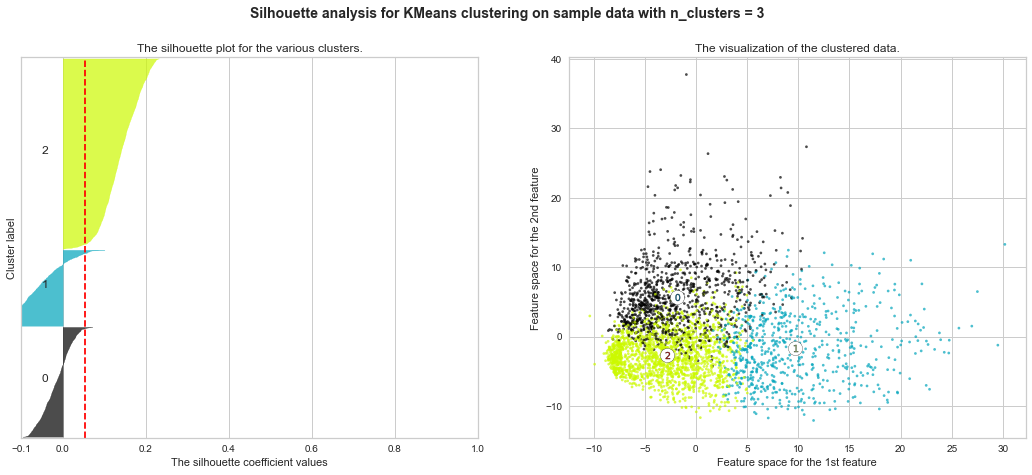

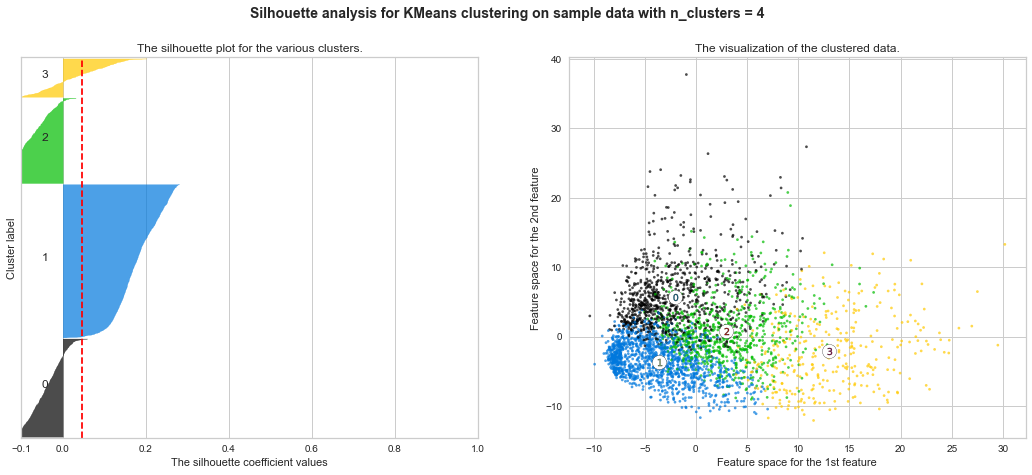

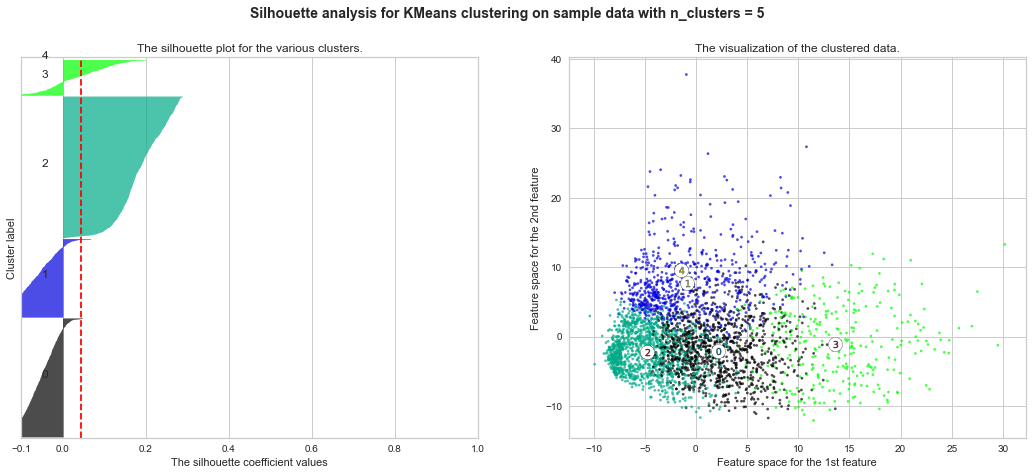

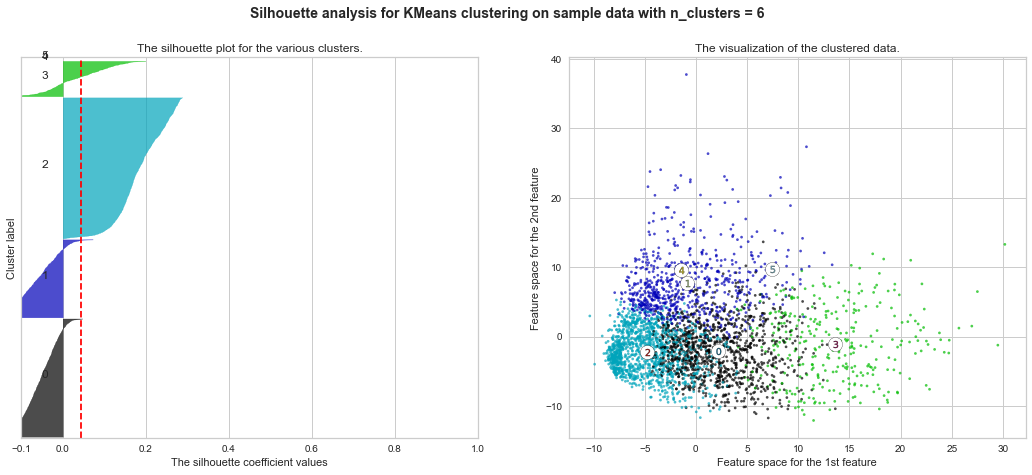

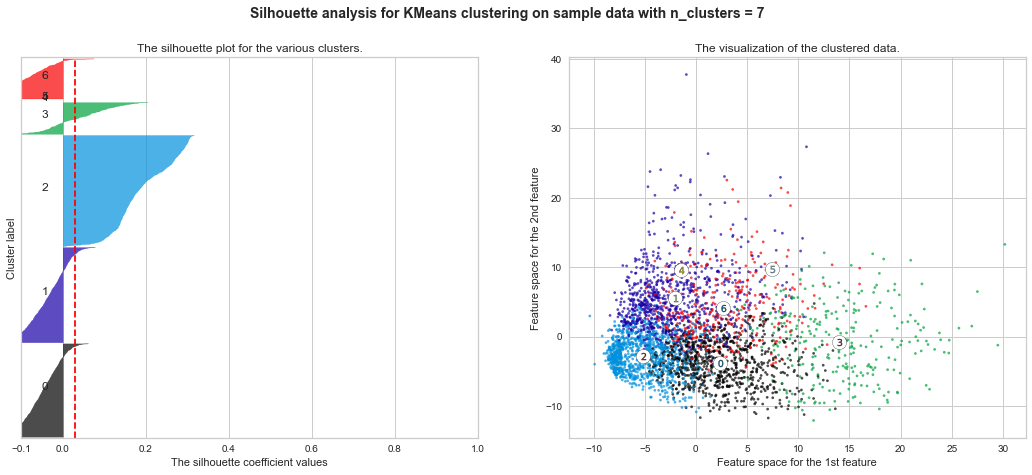

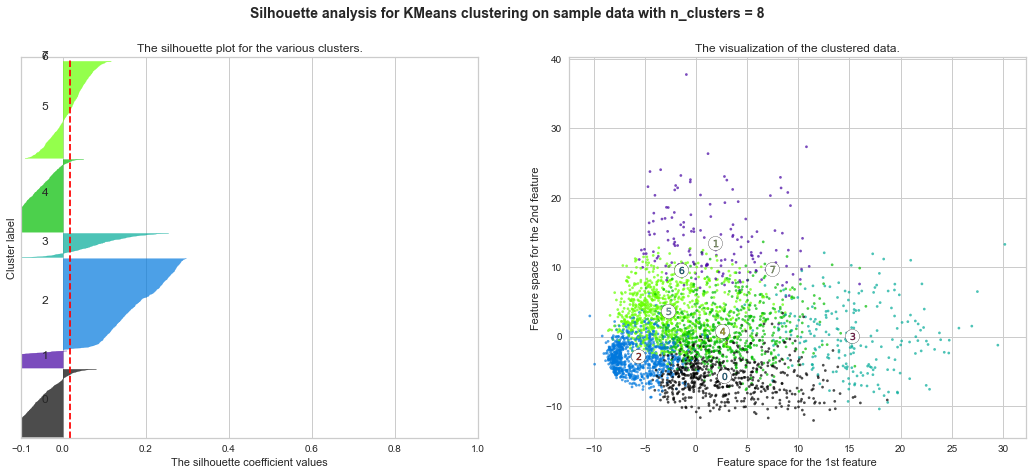

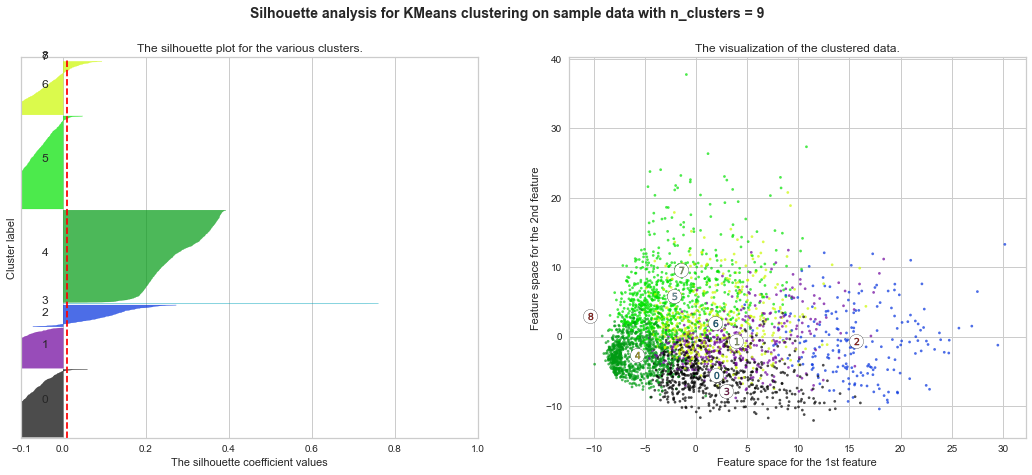

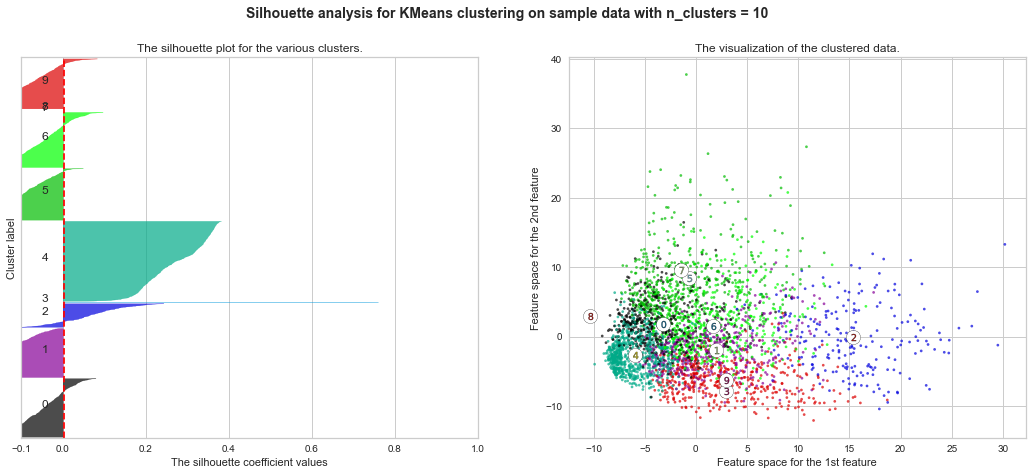

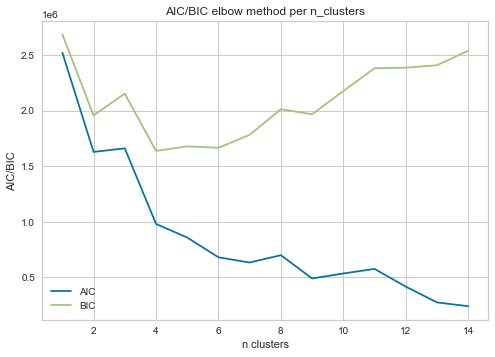

In [32]:
k_means_elbow_viz(pca_X)
k_means_silhouette(pca_X)
GMM_elbow(pca_X, y_train, range_n_clusters=range(1, 15))

In [37]:
print(ica_X.shape)
k_means_elbow_viz(ica_X)
k_means_silhouette(ica_X)
GMM_elbow(ica_X, y_train, range_n_clusters=range(1, 15))

(42000, 602)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
k_means_elbow_viz(RP_X)
k_means_silhouette(RP_X)
GMM_elbow(RP_X, y, range_n_clusters=range(1, 15))

In [ ]:
k_means_elbow_viz(RFC_X)
k_means_silhouette(RFC_X)
GMM_elbow(RFC_X, y, range_n_clusters=range(1, 15))